In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install huggingface-hub

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-tdcik3q1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-tdcik3q1
  Resolved https://github.com/huggingface/transformers.git to commit 6b82d936d49956ba7b43c5ee590f4868de373b65
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7522589 sha256=0e0c142dfa42c32dea47343edbfedd22449a744806a1d8c6369859ca4a0d7ff5
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7w3om5y/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [2]:
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import torch
import collections
import numpy as np

from tqdm.auto import tqdm
from random import sample
from transformers import default_data_collator
from tensorflow import keras
from transformers import AutoTokenizer,AutoModelForQuestionAnswering, TrainingArguments, Trainer

from datasets import Dataset, DatasetDict
sns.set()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
!nvidia-smi

Sat Aug 19 08:09:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### LOAD DATASET

In [4]:
with open("/kaggle/input/qa-ind/train-v2.0.json") as f:
    train = json.loads(f.read())

with open("/kaggle/input/qa-ind/dev-v2.0.json") as f:
    dev = json.loads(f.read())

In [5]:
def format(content):
    hf_data = []
    for data in content["data"]:
        title = data["title"]
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                fill = {
                    "id":  qa["id"],
                    "title": title,
                    "context": context,
                    "question": qa["question"],
                    "answers": {"answer_start": [], "text": []}
                }
                if qa["is_impossible"]:
                    answers = qa["plausible_answers"]
                else:
                    answers = qa["answers"]
                for answer in answers:
                    fill["answers"]["answer_start"].append(answer["answer_start"])
                    fill["answers"]["text"].append(answer["text"])

                hf_data.append(fill)

    return hf_data

In [6]:
dev = format(dev)
train = format(train)

In [7]:
datasets = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(train)),
    'validation': Dataset.from_pandas(pd.DataFrame(dev))
})
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130318
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11858
    })
})

In [8]:
datasets["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/bijanse / bee-YON-say) (lah lahir 4 September 1981) adalah penyanyi Amerika, penulis lagu, produser rekaman dan aktris. Lahir dan dibesarkan di Houston, Texas, dia tampil dalam berbagai kompetisi menyanyi dan menari sebagai seorang anak, dan menjadi terkenal pada akhir 1990-an sebagai penyanyi utama dari R&B gadis-grup Destiny\'s Child. Dikelola oleh ayahnya, Mathew Knowles, kelompok itu menjadi salah satu kelompok gadis terlaris di dunia sepanjang masa. Hiatus mereka melihat rilis album debut Beyonce, Berbahaya dalam Cinta (2003), yang didirikan sebagai artis solo di seluruh dunia, memperoleh lima Grammy Awards dan menampilkan Billboard Hot 100 nomor satu "Gila Cinta" dan "Baby Boy."',
 'question': 'Kapan Beyonce mulai menjadi populer?',
 'answers': {'answer_start': [292], 'text': ['pada akhir 1990-an']}}

### DATA UNDERSTANDING

In [9]:
train_df = pd.DataFrame(train)
train_df

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bijanse / bee...,Kapan Beyonce mulai menjadi populer?,"{'answer_start': [292], 'text': ['pada akhir 1..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/bijanse / bee...,Daerah mana saja yang bersaing dengan Beyonce ...,"{'answer_start': [229], 'text': ['menyanyi dan']}"
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/bijanse / bee...,Kapan Beyonce meninggalkan Destiny's Child dan...,"{'answer_start': [563], 'text': ['2003']}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/bijanse / bee...,Di kota dan negara mana Beyonce tumbuh?,"{'answer_start': [177], 'text': ['Houston, Tex..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/bijanse / bee...,Pada dekade mana Beyonce menjadi terkenal?,"{'answer_start': [297], 'text': ['akhir 1990-a..."
...,...,...,...,...,...
130313,5a7e070b70df9f001a875439,Matter,"Istilah ""materi"" digunakan di seluruh fisika d...",Fisika telah secara luas setuju pada definisi ...,"{'answer_start': [499], 'text': ['materi']}"
130314,5a7e070b70df9f001a87543a,Matter,"Istilah ""materi"" digunakan di seluruh fisika d...",Siapa yang menciptakan istilah partonic matter?,"{'answer_start': [355], 'text': ['Alfvén']}"
130315,5a7e070b70df9f001a87543b,Matter,"Istilah ""materi"" digunakan di seluruh fisika d...",Apa nama lain untuk anti-materi?,"{'answer_start': [382], 'text': ['Gk. common m..."
130316,5a7e070b70df9f001a87543c,Matter,"Istilah ""materi"" digunakan di seluruh fisika d...",Hal biasanya tidak perlu digunakan dalam kaita...,"{'answer_start': [565], 'text': ['dengan pemod..."


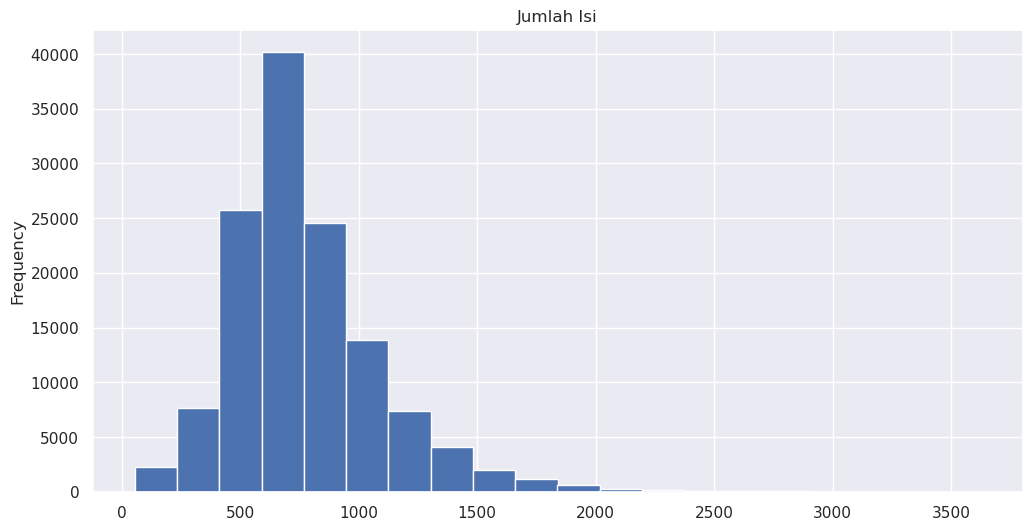

In [10]:
train_df['context'].apply(len).plot.hist(title="Jumlah Isi", bins=20, figsize=(12, 6), grid=True);

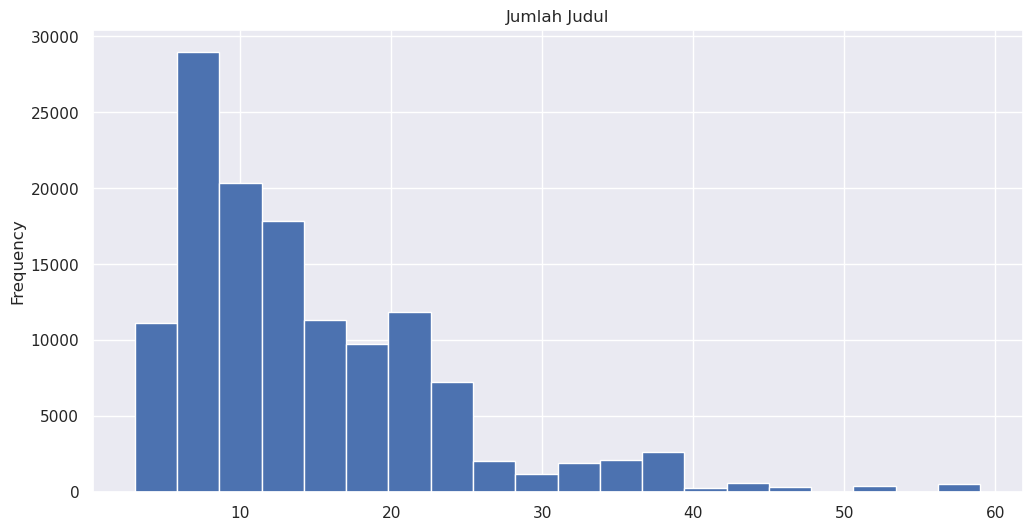

In [11]:
train_df['title'].apply(len).plot.hist(title="Jumlah Judul", bins=20, figsize=(12, 6), grid=True);

<Axes: xlabel='title', ylabel='Density'>

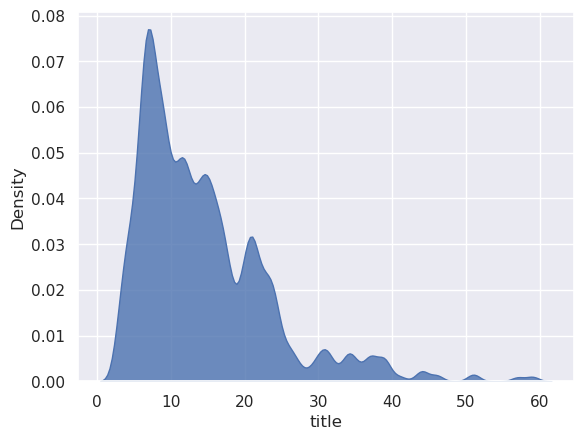

In [12]:
sns.kdeplot(data=train_df["title"].apply(len), fill=True, alpha=0.8)

### TEXT PREPROCESSING

In [13]:
model_checkpoint = "indolem/indobert-base-uncased"
batch_size = 16

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer("kamu lagi ngapain")

{'input_ids': [3, 3162, 1975, 31546, 4], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [14]:
jumAcak = 1
print(sample(datasets["train"][:]["context"], jumAcak))
print()
tokenizer(sample(datasets["train"][:]["context"], jumAcak))

['Paus meminta perang salib untuk berlangsung di tempat lain selain Tanah Suci: di Spanyol, Prancis bagian selatan, dan di sepanjang Baltik. Perang salib Spanyol menjadi menyatu dengan Reconquista Spanyol dari Muslim. Meskipun para Templar dan Rumah Sakit ikut serta dalam perang salib Spanyol, perintah keagamaan militer Spanyol yang serupa didirikan, yang sebagian besar telah menjadi bagian dari dua perintah utama Calatrava dan Santiago pada awal abad ke - 12. Eropa Utara juga tetap berada di luar pengaruh Kristen hingga abad ke - 11 atau belakangan, dan menjadi tempat yang sulit sebagai bagian dari Perang Salib Utara dari abad ke - 12 hingga 14. Perang salib ini juga melahirkan perintah militer, Orde Saudara Pedang. Urutan lain, Ksatria Teutonik, meskipun awalnya didirikan di negara - negara bagian pejuang salib, memfokuskan sebagian besar kegiatannya di Baltik setelah tahun 1225, dan pada tahun 1309 memindahkan kantor pusatnya ke Marienburg di Prusia.']



{'input_ids': [[3, 2964, 2336, 16, 1779, 2510, 1703, 5021, 1737, 2844, 3040, 12567, 1814, 7180, 1519, 1542, 9890, 2011, 16, 2304, 3618, 3674, 1501, 8367, 18, 1779, 2510, 1501, 12582, 7961, 13746, 933, 1614, 1703, 16814, 3627, 1501, 3618, 1497, 2399, 2318, 1485, 2844, 3880, 1497, 3464, 1819, 1842, 2785, 17, 7379, 2011, 16, 2304, 6, 5013, 1737, 1732, 1855, 4870, 2036, 1766, 8107, 1497, 5703, 11, 3010, 11, 10873, 1633, 6, 1497, 7115, 1560, 4812, 6, 3103, 31213, 1487, 2011, 5679, 1485, 2420, 8107, 4395, 1485, 5384, 1501, 1766, 3722, 4395, 1485, 19943, 6, 16, 3627, 11, 9439, 15074, 11, 1497, 4070, 1542, 2407, 1766, 3722, 2011, 6, 4395, 1558, 9439, 8107, 1633, 16, 6, 1501, 3627, 1730, 6, 7779, 11, 5304, 11, 16, 11, 4122, 11, 10873, 16, 1501, 11, 8033, 1476, 11, 16, 1708, 21876, 2021, 1500, 3618, 2011, 11, 12, 8352, 5264, 1768, 15327, 1920, 933, 13, 16, 2125, 12, 8352, 6071, 1503, 11, 12, 8352, 10303, 1503, 13, 16, 3683, 1497, 10062, 3344, 12, 50, 13, 18, 1779, 2510, 1703, 9426, 4520, 5417, 1

In [15]:
max_length = 500  # The maximum length of a feature (question and context)
doc_stride = 64   # The authorized overlap between two part of the context when splitting it is needed.

In [16]:
tanya = datasets["train"][0]["question"]
print(tanya)
print("--"*10)
tokenizer(tanya)

Kapan Beyonce mulai menjadi populer?
--------------------


{'input_ids': [3, 6404, 18770, 7609, 929, 2198, 1649, 5208, 35, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
tokenized_example = tokenizer(
    datasets["train"][:]["question"],
    datasets["train"][:]["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [18]:
len(tokenized_example["input_ids"])

130486

In [19]:
### Mengecek pasangan question context dalam bentuk token

tokenized_example["input_ids"][0]

[3,
 6404,
 18770,
 7609,
 929,
 2198,
 1649,
 5208,
 35,
 4,
 18770,
 7609,
 929,
 25734,
 13380,
 12405,
 4468,
 17,
 18691,
 12,
 19,
 8175,
 2208,
 929,
 19,
 30153,
 17,
 13785,
 17,
 3134,
 13,
 12,
 5360,
 3054,
 24,
 3264,
 8743,
 13,
 1581,
 4896,
 2255,
 16,
 3188,
 2574,
 16,
 8490,
 5995,
 1501,
 7504,
 18,
 3054,
 1501,
 11825,
 1485,
 24756,
 16,
 13938,
 16,
 1801,
 3918,
 1558,
 2190,
 5182,
 12650,
 1501,
 12393,
 1624,
 1822,
 1827,
 16,
 1501,
 1649,
 3515,
 1560,
 2010,
 5404,
 17,
 1550,
 1624,
 4896,
 2408,
 1542,
 60,
 10,
 44,
 4944,
 17,
 3782,
 26848,
 950,
 11,
 61,
 21353,
 18,
 8781,
 1617,
 4618,
 16,
 17426,
 1729,
 12405,
 4468,
 16,
 2486,
 1570,
 1649,
 1911,
 1713,
 2486,
 4944,
 19949,
 1485,
 1950,
 3318,
 2106,
 18,
 3523,
 3071,
 1633,
 2415,
 10895,
 3019,
 6116,
 18770,
 7609,
 929,
 16,
 6239,
 1558,
 3663,
 12,
 3936,
 13,
 16,
 1497,
 4093,
 1624,
 5516,
 5421,
 1485,
 2313,
 1950,
 16,
 3766,
 2715,
 20482,
 7832,
 1501,
 5346,
 13831,
 3725

In [20]:
for x in tokenized_example["input_ids"][0]:
    print(tokenizer.decode(x))

[CLS]
kapan
bey
##onc
##e
mulai
menjadi
populer
?
[SEP]
bey
##onc
##e
gis
##elle
know
##les
-
carter
(
/
bij
##ans
##e
/
bee
-
yon
-
say
)
(
lah
lahir
4
september
1981
)
adalah
penyanyi
amerika
,
penulis
lagu
,
produser
rekaman
dan
aktris
.
lahir
dan
dibesarkan
di
houston
,
texas
,
dia
tampil
dalam
berbagai
kompetisi
menyanyi
dan
menari
sebagai
seorang
anak
,
dan
menjadi
terkenal
pada
akhir
1990
-
an
sebagai
penyanyi
utama
dari
r
&
b
gadis
-
grup
destin
##y
'
s
child
.
dikelola
oleh
ayahnya
,
math
##ew
know
##les
,
kelompok
itu
menjadi
salah
satu
kelompok
gadis
terlaris
di
dunia
sepanjang
masa
.
hi
##atus
mereka
melihat
rilis
album
debut
bey
##onc
##e
,
berbahaya
dalam
cinta
(
2003
)
,
yang
didirikan
sebagai
artis
solo
di
seluruh
dunia
,
memperoleh
lima
grammy
awards
dan
menampilkan
billboard
hot
100
nomor
satu
"
gila
cinta
"
dan
"
baby
boy
.
"
[SEP]


In [21]:
pad_on_right = tokenizer.padding_side == "right"

In [22]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a
    # stride. This results in one example possible giving several features when a context is long,
    # each of those features having a context that overlaps a bit the context of the previous
    # feature.
    examples["question"] = [q.lstrip() for q in examples["question"]]
    examples["context"] = [c.lstrip() for c in examples["context"]]
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a
    # map from a feature to its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original
    # context. This will help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what
        # is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this
        # span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the
            # CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the
                # answer.
                # Note: we could go after the last offset if the answer is the last word (edge
                # case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [23]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

  0%|          | 0/131 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 130486
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 11929
    })
})

### FINE TUNING MODEL

In [25]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
args = TrainingArguments(
    f"/kaggle/working/",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01
)

In [27]:
data_collator = default_data_collator

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [29]:
wandb.init()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [47]:
# # Untuk melatih dari awal
# trainer.train()

# Untuk melanjutkan training supaya tidak dari awal / pre-trained model
trainer.train("/kaggle/input/checkpoint-2")

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=24468, training_loss=0.0, metrics={'train_runtime': 0.2327, 'train_samples_per_second': 1681973.604, 'train_steps_per_second': 105131.407, 'total_flos': 9.9889361131212e+16, 'train_loss': 0.0, 'epoch': 3.0})

In [31]:
# trainer.save_model("pretrained_qa_ind.pt")

### LOAD MODEL

In [32]:
# from transformers import pipeline

# model_checkpoint = "/kaggle/input/checkpoint-2"

# qa_pipeline = pipeline(
#     "question-answering",
#     model=model_checkpoint,
#     tokenizer=model_checkpoint
# )

# qa_pipeline({
#     'context': """
#         Nama : Prof. Dr.-Ing. H. Bacharuddin Jusuf Habibie
# Panggilan Populer : BJ Habibie
# Istri : Hasri Ainun Besari
# Tempat, Tanggal, Lahir :Pare-pare, 25 Juni 1936
# Masa Jabatan Presiden : 21 Mei 1998 Sampai 20 Oktober 1999
# Riwayat Pendidikan : SMAK Dago, Bandung, Institut Teknologi Bandung (ITB), RWTH Aachen
# Nama Anak-anak : Ilham Akbar, Thareq Kemal

# Bernama lengkap Bacharuddin Jusuf Habibie ini lahir di Kota Pare-Pare Sulawesi Selatan pada tanggal 25 Juni 1936. Sebelum menjadi orang yang berpengaruh bagi bangsa Indonesia, BJ Habibie pernah mengenyam pendidikan di SMAK Dago, Bandung, tahun 1954 dan melanjutkan ke perguruan tinggi di Institut Teknologi Bandung (ITB).

# Karena kepintaran dan kecerdasannya, BJ Habibie akhirnya melanjutkan studinya di Jerman bersama teman-temannya yang lain. Berbeda dengan teman-temannya yang menggunakan beasiswa untuk kuliah di Jerman, BJ Habibie menggunakan biaya dari ibunya, R.A Tuti Marini Puspowardojo.

# Keputusannya belajar di Jerman karena petuah Bung Karno tentang pentingnya penguasaan teknologi nasional, yakni teknologi maritim dan teknologi dirgantara saat Indonesia masih berkembang saat itu.

# BJ Habibie akhirnya memilih jurusan Teknik Penerbangan spesialis Konstruksi Pesawat Terbang di Rhein Westfalen Aachen Technische Hochschule, Jerman pada tahun 1955.

# Dari sinilah BJ Habibie belajar menguasai teknologi dan menjadi ahli pesawat terbang yang pertama kali menciptakan pesawat terbang di Indonesia. Jadi tidak heran jika ia dijuluki sebagai bapak teknologinya Indonesia karena karyanya yang luar biasa.

# Banyak pelajaran yang bisa kita ambil dari kisah hidup atau biografi BJ Habibie. Meskipun masa jabatan presiden BJ Habibie sangat singkat, namun ia adalah salah satu tokoh bangsa yang membawa sprit kebangsaan dan perubahan bagi bangsa Indonesia secara Intelektual.
#     """,
#     'question': "memilih jurusan apa bj habibie?"
# })

### EVALUATION 

In [48]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [49]:
print(f"loss : {output['loss']}")

loss : 1.4319185018539429


In [50]:
# n_best_size = 20

# def prepare_validation_features(examples):
#     # Some of the questions have lots of whitespace on the left, which is not useful and will make the
#     # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
#     # left whitespace
#     examples["question"] = [q.lstrip() for q in examples["question"]]

#     # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
#     # in one example possible giving several features when a context is long, each of those features having a
#     # context that overlaps a bit the context of the previous feature.
#     tokenized_examples = tokenizer(
#         examples["question" if pad_on_right else "context"],
#         examples["context" if pad_on_right else "question"],
#         truncation="only_second" if pad_on_right else "only_first",
#         max_length=max_length,
#         stride=doc_stride,
#         return_overflowing_tokens=True,
#         return_offsets_mapping=True,
#         padding="max_length",
#     )

#     # Since one example might give us several features if it has a long context, we need a map from a feature to
#     # its corresponding example. This key gives us just that.
#     sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

#     # We keep the example_id that gave us this feature and we will store the offset mappings.
#     tokenized_examples["example_id"] = []

#     for i in range(len(tokenized_examples["input_ids"])):
#         # Grab the sequence corresponding to that example (to know what is the context and what is the question).
#         sequence_ids = tokenized_examples.sequence_ids(i)
#         context_index = 1 if pad_on_right else 0

#         # One example can give several spans, this is the index of the example containing this span of text.
#         sample_index = sample_mapping[i]
#         tokenized_examples["example_id"].append(examples["id"][sample_index])

#         # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
#         # position is part of the context or not.
#         tokenized_examples["offset_mapping"][i] = [
#             (o if sequence_ids[k] == context_index else None)
#             for k, o in enumerate(tokenized_examples["offset_mapping"][i])
#         ]

#     return tokenized_examples

In [51]:
# validation_features = datasets["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=datasets["validation"].column_names
# )

In [52]:
datasets["validation"][200]

{'id': '56de51c64396321400ee27f8',
 'title': 'Normans',
 'context': 'Normandia adalah lokasi beberapa perkembangan penting dalam sejarah musik klasik pada abad ke - 11. Fécamp Abbey dan Saint-Evroul Abbey adalah pusat produksi musik dan pendidikan. Di Fécamp, di bawah dua kepala biara Italia, William dari Volpiano dan John dari Ravenna, sistem penorehan catatan melalui surat dikembangkan dan diajarkan. Hal ini masih merupakan bentuk umum representasi lapangan di Inggris-dan Jerman negara-bahasa saat ini. Selain itu, di Fécamp, tongkat yang kira - kira berorientasi pada neum, pertama kali dikembangkan dan diajarkan pada abad ke - 11. Di bawah abbot Jerman Isebarrd, La Trinité-du-Mont menjadi pusat komposisi musik.',
 'question': 'Siapa dua kepala biara di Fécamp Abbey?',
 'answers': {'answer_start': [225, 225, 225],
  'text': ['William dari Volpiano dan John dari Ravenna',
   'William dari Volpiano dan John dari Ravenna',
   'William dari Volpiano dan John dari Ravenna']}}

In [53]:
data_test = pd.DataFrame({
    "id": [1],
    "context" : ['Ibuku adalah orang Jawa, sedangkan ayahku adalah orang Minang. Kakek-nenekku berasal dari daerah yang sama seperti ibu dan ayahku. Meskipun berasal dari daerah yang berbeda, kami bisa tetap hidup dengan harmonis.'],
    'question' : ['orang mana kakek neneknya?'],
})
data_test

,id,context,question
0,1,"Ibuku adalah orang Jawa, sedangkan ayahku adal...",orang mana kakek neneknya?


In [54]:
data_test = Dataset.from_pandas(data_test)
data_test

Dataset({
    features: ['id', 'context', 'question'],
    num_rows: 1
})

In [55]:
n_best_size = 20

def prepare_validation_features2(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [56]:
validation_features2 = data_test.map(
    prepare_validation_features2,
    batched=True,
    remove_columns=data_test.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [57]:
raw_predictions2 = trainer.predict(validation_features2)
raw_predictions2

PredictionOutput(predictions=(array([[ -8.727151  ,  -9.400266  ,  -9.855542  ,  -9.521359  ,
         -9.949315  , -10.4413    , -10.691624  ,  -0.259843  ,
         -4.072275  ,  -2.3291354 ,   1.1485639 ,  -8.742288  ,
         -1.9910593 ,   0.48647955,  -2.7278252 ,  -0.39374334,
          2.977145  ,  -4.9215503 ,   0.9203992 ,  -4.938262  ,
         -2.9989023 ,  -1.1131386 ,   1.5885342 ,   1.5242252 ,
          1.7916719 ,  -1.3147528 ,  -0.09369452,  -2.460136  ,
          1.5457159 ,  -3.522297  ,   1.4809103 ,  -4.921612  ,
         -4.179038  ,  -2.0659063 ,  -2.4305186 ,  -0.5430629 ,
         -6.1052227 ,  -2.8489022 ,  -9.670073  ,  -4.6176357 ,
         -6.8337154 ,  -6.446458  ,  -5.6826005 ,  -6.4525776 ,
         -4.08222   ,  -5.0582027 , -10.742445  , -10.723532  ,
        -10.763874  , -10.753521  , -10.730685  , -10.719391  ,
        -10.734564  , -10.754829  , -10.760138  , -10.769725  ,
        -10.753     , -10.672696  , -10.581425  , -10.5149975 ,
        -1

In [58]:
impossible_answer = True

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
#         if not impossible_answer:
#             predictions[example["id"]] = best_answer["text"]
#         else:
#             answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
#             predictions[example["id"]] = answer

#     return predictions
    return best_answer

final_predictions2 = postprocess_qa_predictions(data_test, validation_features2, raw_predictions2.predictions)

Post-processing 1 example predictions split into 1 features.


  0%|          | 0/1 [00:00<?, ?it/s]

In [59]:
def hasilAkhir(a, b, prediksi):
    context, question = "", ""
    
    for x in a:
        context = x
    for y in b:
        question = y
        
    print(f"Context : {context}")
    print(f"Question : {question}")
    print()
    print(f"Prediksi : Score {prediksi['score']} : {prediksi['text']}")
    
hasilAkhir(data_test["context"], data_test["question"], final_predictions2)

Context : Ibuku adalah orang Jawa, sedangkan ayahku adalah orang Minang. Kakek-nenekku berasal dari daerah yang sama seperti ibu dan ayahku. Meskipun berasal dari daerah yang berbeda, kami bisa tetap hidup dengan harmonis.
Question : orang mana kakek neneknya?

Prediksi : Score 6.103889465332031 : Minang


In [45]:
# model.push_to_hub("transformers-qa", organization="keras-io")
# tokenizer.push_to_hub("transformers-qa", organization="keras-io")

In [46]:
# from huggingface_hub.keras_mixin import push_to_hub_keras

# push_to_hub_keras(
#     model=model, repo_url="https://huggingface.co/your-username/your-awesome-model"
# )
# from_pretrained_keras("your-username/your-awesome-model") # load your model